# Librerias requeridas

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
import joblib
import os
import time
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error)
from sklearn.inspection import permutation_importance
from scipy import stats as sp_stats

# Importar datos

In [3]:
#Data sets despues de eliminar variables de alta correlacion
Data_regres_filtrado = pd.read_csv("../data/wine_data_train_regression_filtrado.csv")
Data_regres_filtrado = pd.DataFrame(Data_regres_filtrado)
print(f"\n🔹 Columnas en regresion:\n{Data_regres_filtrado.columns.tolist()}")


🔹 Columnas en regresion:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


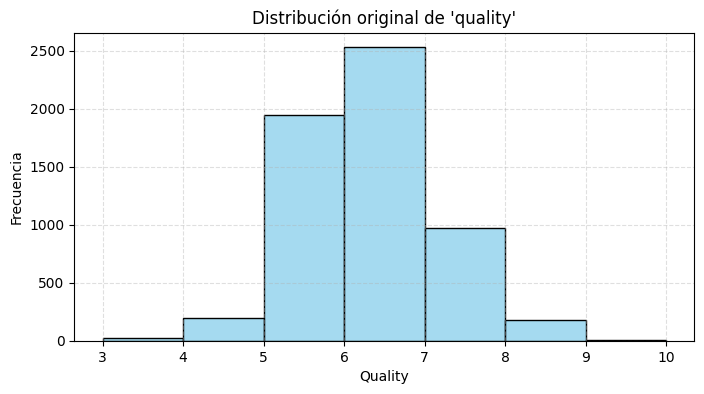

In [4]:
# ==============================================
# 📊 Distribución de la variable objetivo 'quality'
# ==============================================

# Histograma original (valores numéricos)
plt.figure(figsize=(8,4))
sns.histplot(Data_regres_filtrado['quality'], bins=range(3, 11), kde=False, color='skyblue', edgecolor='black')
plt.title("Distribución original de 'quality'")
plt.xlabel("Quality")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()



In [5]:
# =====================================================
# 🧹 PREPROCESAMIENTO Y DIVISIÓN DE DATOS (CELDA BASE)
# =====================================================
#@markdown En esta celda se prepara el dataset de regresión:
#@markdown - Se eliminan columnas no numéricas  
#@markdown - Se limpian valores infinitos o faltantes  
#@markdown - Se divide el conjunto en entrenamiento y prueba (80/20)


# --- 1️⃣ Detección de columnas no numéricas
no_numericas = Data_regres_filtrado.select_dtypes(exclude=np.number).columns.tolist()
print(f"🔍 Columnas no numéricas detectadas: {no_numericas}")

# --- 2️⃣ Selección de solo variables numéricas y separación de target
X = Data_regres_filtrado.select_dtypes(include=np.number).drop(columns=["quality"])
y = Data_regres_filtrado["quality"]

# --- 3️⃣ Limpieza de valores infinitos o faltantes
X = X.replace([np.inf, -np.inf], np.nan).dropna()

print(f"✅ Dataset final listo para modelado: {X.shape[0]} observaciones y {X.shape[1]} variables numéricas.\n")

# --- 4️⃣ División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y.loc[X.index], test_size=0.2, random_state=42
)

print(f"📂 Tamaño del set de entrenamiento: {X_train.shape[0]}")
print(f"📂 Tamaño del set de prueba: {X_test.shape[0]}\n")


🔍 Columnas no numéricas detectadas: []
✅ Dataset final listo para modelado: 5847 observaciones y 10 variables numéricas.

📂 Tamaño del set de entrenamiento: 4677
📂 Tamaño del set de prueba: 1170



In [20]:

# ================================================================================
# PASO 5: MODELO BASELINE (CON PARÁMETROS CALIBRADOS)
# ================================================================================
#@markdown En este paso se entrena un modelo **Random Forest Regressor** con los
#@markdown parámetros ajustados actualmente (según calibración previa).  
#@markdown Se evalúa el rendimiento en train y test mediante R², RMSE, MAE y MAPE.

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
)
import numpy as np

print("="*80)
print("🎯 MODELO BASELINE - Random Forest Regressor (Calibrado)")
print("="*80)

# Crear y entrenar modelo baseline con los parámetros actuales
rf_calibrado = RandomForestRegressor(
    n_estimators=602,        # Número de árboles
    max_depth=20,          # Sin límite de profundidad
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,
)

print("\n⏳ Entrenando modelo calibrado...")
rf_calibrado.fit(X_train, y_train)
print("✅ Entrenamiento completado.")

# Predicciones
y_train_pred = rf_calibrado.predict(X_train)
y_test_pred = rf_calibrado.predict(X_test)

# ================================================================================
# 📊 MÉTRICAS DE DESEMPEÑO
# ================================================================================
print(f"\n{'Métrica':<25} {'Train':<15} {'Test':<15}")
print("-" * 55)

# R² Score
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"{'R² Score':<25} {r2_train:<15.4f} {r2_test:<15.4f}")

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"{'RMSE':<25} {rmse_train:<15.4f} {rmse_test:<15.4f}")

# MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"{'MAE':<25} {mae_train:<15.4f} {mae_test:<15.4f}")

# MAPE
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
print(f"{'MAPE (%)':<25} {mape_train*100:<15.2f} {mape_test*100:<15.2f}")

# ================================================================================
# 💬 INTERPRETACIÓN
# ================================================================================
print("\n💡 Interpretación:")
print(f"   • R² Test:  {r2_test:.4f}  → Explica el {r2_test*100:.2f}% de la varianza en la calidad del vino.")
print(f"   • RMSE Test: {rmse_test:.4f}  → Error cuadrático medio de ±{rmse_test:.2f} puntos de calidad.")
print(f"   • MAE Test:  {mae_test:.4f}  → Error absoluto medio de ±{mae_test:.2f} puntos de calidad.\n")


🎯 MODELO BASELINE - Random Forest Regressor (Calibrado)

⏳ Entrenando modelo calibrado...
✅ Entrenamiento completado.
✅ Entrenamiento completado.

Métrica                   Train           Test           
-------------------------------------------------------
R² Score                  0.9981          0.5322         
RMSE                      0.0379          0.5917         
MAE                       0.0223          0.3860         
MAPE (%)                  0.40            7.07           

💡 Interpretación:
   • R² Test:  0.5322  → Explica el 53.22% de la varianza en la calidad del vino.
   • RMSE Test: 0.5917  → Error cuadrático medio de ±0.59 puntos de calidad.
   • MAE Test:  0.3860  → Error absoluto medio de ±0.39 puntos de calidad.


Métrica                   Train           Test           
-------------------------------------------------------
R² Score                  0.9981          0.5322         
RMSE                      0.0379          0.5917         
MAE                   

| Gráfico                         | Qué muestra                        | Interpretación                                                                                               |
| ------------------------------- | ---------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **Evolución del R² (CV)**       | Cada punto = configuración probada | Variación natural; varias combinaciones se acercan al óptimo (≈0.47), indicando **robustez**.                |
| **Overfitting (Train vs Test)** | R² CV-train vs CV-test             | El mejor modelo (estrella roja) está **cerca de la diagonal**, → buen balance entre ajuste y generalización. |
| **Distribución de Scores**      | Histograma de R² CV                | Concentrado entre 0.35–0.47 → la mayoría de configuraciones razonables; espacio bien definido.               |
| **Impacto de n_estimators**     | Relación árboles ↔ R²              | Tendencia plana → más de ~300 árboles **no mejoran sustancialmente**.                                        |
| **Impacto de max_depth**        | Boxplots por profundidad           | `40` y `None` dan los mejores resultados → árboles profundos son útiles.                                     |
| **Impacto de max_features**     | Diferentes estrategias             | `'sqrt'` domina; `'log2'` tiene menor rendimiento → confirma que la calibración original era adecuada.       |
| **Impacto de bootstrap**        | True vs False                      | `False` obtiene mejores medianas → usar todo el dataset mejora consistencia.                                 |


🔍 OPTIMIZACIÓN DE HIPERPARÁMETROS CON RANDOMIZEDSEARCHCV

────────────────────────────────────────────────────────────────────────────────
📋 ESPACIO DE BÚSQUEDA DE HIPERPARÁMETROS
────────────────────────────────────────────────────────────────────────────────

- n_estimators        : randint(200, 600)   → incluye 300 (calibrado)
- max_depth           : [10, 20, 30, 40, None]
- min_samples_split   : randint(2, 20)
- min_samples_leaf    : randint(1, 10)
- max_features        : ['sqrt', 'log2', None]  (incluye 'sqrt')
- bootstrap           : [True, False]


⏳ Iniciando búsqueda aleatoria (50 iteraciones, CV=5)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ OPTIMIZACIÓN COMPLETADA en 1.81 min (108.7 s)

🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS
• bootstrap         : False
• max_depth         : 40
• max_features      : sqrt
• min_samples_leaf  : 1
• min_samples_split : 9
• n_estimators      : 327

📊 Mejor R² (CV): 0.4733 | Ranking: 40 / 50

📊 MÉTRICAS DEL MEJOR MODELO (ENTR

C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1244079644.py:185: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax5.boxplot(data_md, labels=labels_md, patch_artist=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1244079644.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax6.boxplot(data_mf, labels=unique_mf, patch_artist=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1244079644.py:205: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = ax7.boxplot(data_bs, labels=['True','False'], patch_artist=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1244079644.py:211: UserWarning: 

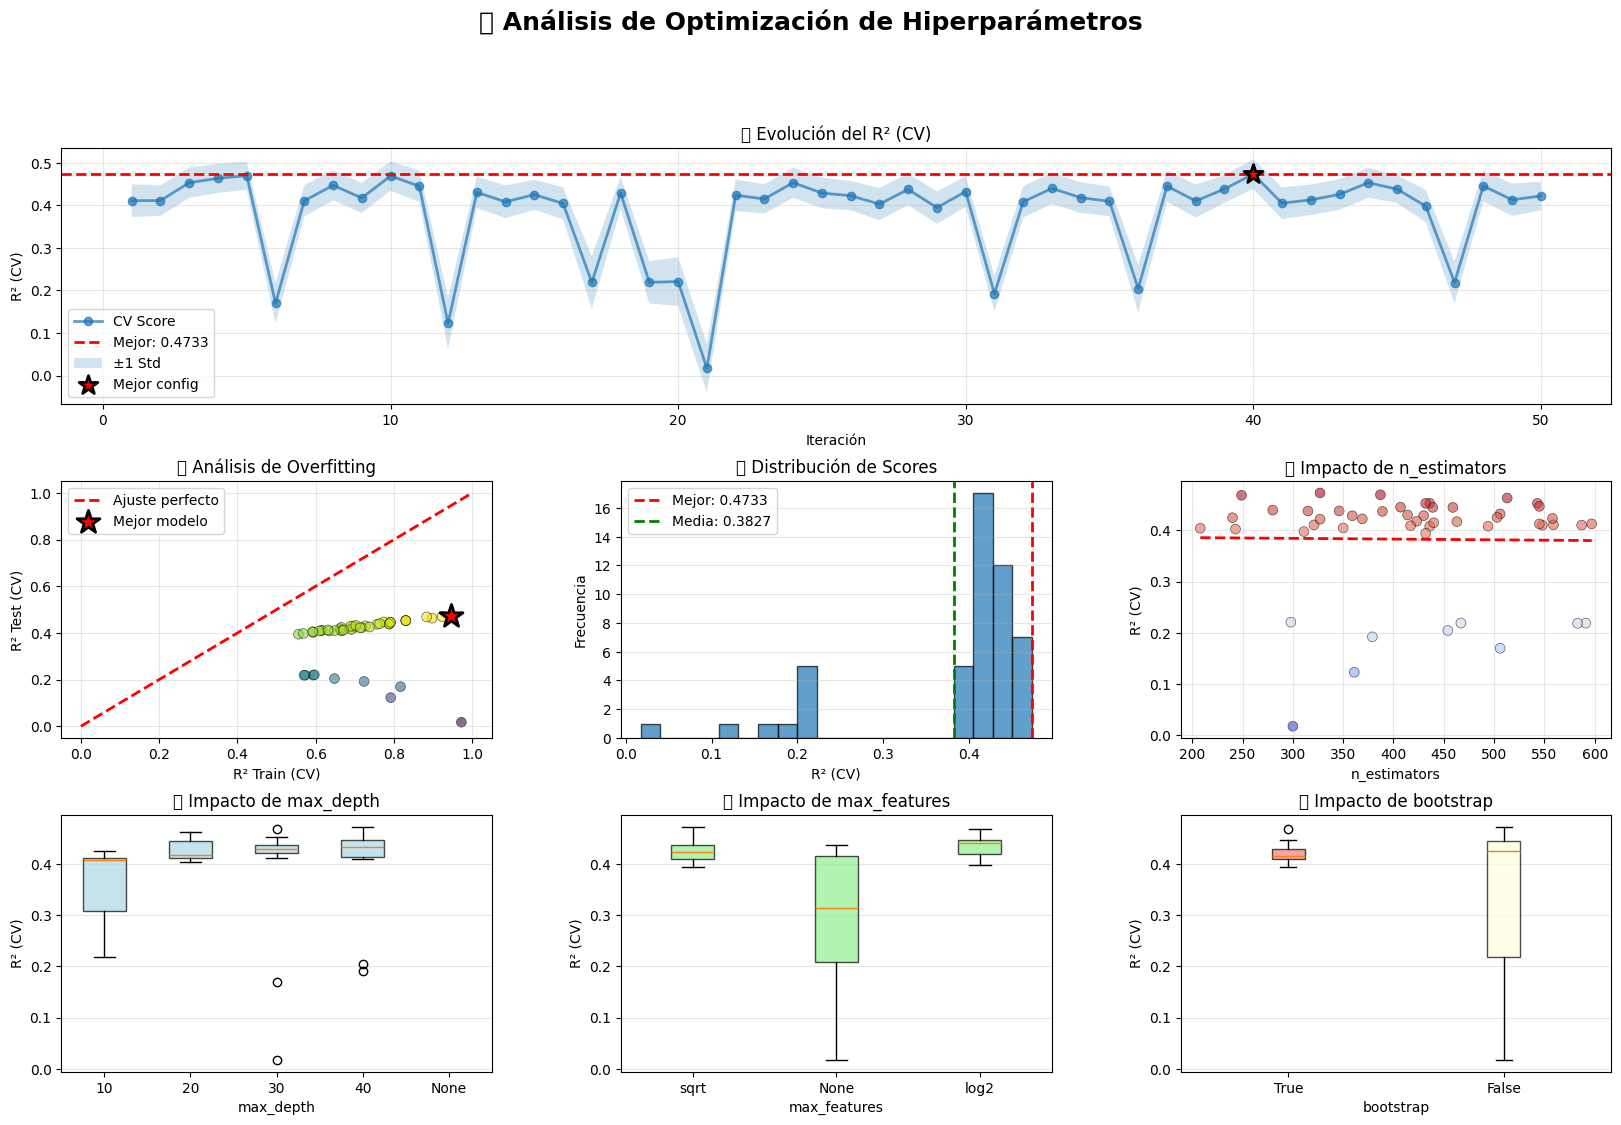


🏅 TOP 10 MEJORES CONFIGURACIONES (por mean_test_score)
 mean_test_score  std_test_score  param_n_estimators param_max_depth  param_min_samples_split  param_min_samples_leaf param_max_features  param_bootstrap  rank_test_score
        0.473275        0.034791                 327              40                        9                       1               sqrt            False                1
        0.469659        0.032976                 387            None                       11                       1               sqrt            False                2
        0.468729        0.034704                 249              30                        5                       1               log2             True                3
        0.463291        0.034182                 513              20                       13                       1               sqrt            False                4
        0.453014        0.035257                 436            None                     

In [7]:
# ================================================================================
# PASO 6: OPTIMIZACIÓN CON RANDOMIZEDSEARCHCV
# ================================================================================
#@markdown En este paso se optimizan los hiperparámetros del Random Forest mediante
#@markdown **RandomizedSearchCV (5-fold CV)**. Se reportan mejores parámetros,
#@markdown evolución de scores y análisis gráfico del espacio explorado.



print("="*80)
print("🔍 OPTIMIZACIÓN DE HIPERPARÁMETROS CON RANDOMIZEDSEARCHCV")
print("="*80)

# ------------------------------------------------------------------------------
# Baseline de referencia (si no traemos r2_test desde el PASO 5, lo calculamos aquí)
# ------------------------------------------------------------------------------
try:
    _ = r2_test  # solo para chequear existencia
    baseline_disponible = True
except NameError:
    baseline_disponible = False

if not baseline_disponible:
    rf_calibrado = RandomForestRegressor(
        n_estimators=300, max_depth=None,
        min_samples_split=2, min_samples_leaf=1,
        max_features='sqrt', random_state=42, n_jobs=-1
    )
    print("\n⏳ Entrenando baseline calibrado (referencia previa ausente)...")
    rf_calibrado.fit(X_train, y_train)
    y_test_pred_base = rf_calibrado.predict(X_test)
    y_train_pred_base = rf_calibrado.predict(X_train)

    r2_train = r2_score(y_train, y_train_pred_base)
    r2_test  = r2_score(y_test,  y_test_pred_base)
    rmse_test = mean_squared_error(y_test, y_test_pred_base, squared=False)
    mae_test  = mean_absolute_error(y_test, y_test_pred_base)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred_base)

    print("✅ Baseline calibrado entrenado (para referencia en el resumen)")
    print(f"   R² Train: {r2_train:.4f} | R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f} | MAE Test: {mae_test:.4f}")

# ------------------------------------------------------------------------------
# Espacio de búsqueda (incluye la calibración actual en el rango)
# ------------------------------------------------------------------------------
param_distributions = {
    'n_estimators': randint(200, 600),          # incluye 300
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],     # incluye 'sqrt' (nuestra calibración)
    'bootstrap': [True, False]
}

print("\n" + "─"*80)
print("📋 ESPACIO DE BÚSQUEDA DE HIPERPARÁMETROS")
print("─"*80)
print(f"""
- n_estimators        : randint(200, 600)   → incluye 300 (calibrado)
- max_depth           : {param_distributions['max_depth']}
- min_samples_split   : randint(2, 20)
- min_samples_leaf    : randint(1, 10)
- max_features        : {param_distributions['max_features']}  (incluye 'sqrt')
- bootstrap           : {param_distributions['bootstrap']}
""")

# ------------------------------------------------------------------------------
# Configurar y ejecutar RandomizedSearchCV
# ------------------------------------------------------------------------------
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=50,                  # combinaciones a probar
    cv=5,                       # 5-fold CV
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

print("\n⏳ Iniciando búsqueda aleatoria (50 iteraciones, CV=5)...\n" + "="*80)
start_time = time.time()
random_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print("="*80)
print(f"✅ OPTIMIZACIÓN COMPLETADA en {elapsed_time/60:.2f} min ({elapsed_time:.1f} s)")

# ------------------------------------------------------------------------------
# Resultados y mejor modelo
# ------------------------------------------------------------------------------
best_params = random_search.best_params_
best_score  = random_search.best_score_
best_rf     = random_search.best_estimator_

print("\n" + "="*80)
print("🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS")
print("="*80)
for k, v in best_params.items():
    print(f"• {k:<18}: {v}")
print(f"\n📊 Mejor R² (CV): {best_score:.4f} | Ranking: {random_search.best_index_ + 1} / 50")

# ------------------------------------------------------------------------------
# Evaluación del mejor modelo en TEST
# ------------------------------------------------------------------------------
y_test_pred_opt = best_rf.predict(X_test)
y_train_pred_opt = best_rf.predict(X_train)

r2_train_opt = r2_score(y_train, y_train_pred_opt)
r2_test_opt  = r2_score(y_test,  y_test_pred_opt)
rmse_test_opt = np.sqrt(mean_squared_error(y_test, y_test_pred_opt))

mae_test_opt  = mean_absolute_error(y_test, y_test_pred_opt)
mape_test_opt = mean_absolute_percentage_error(y_test, y_test_pred_opt)

print("\n" + "="*80)
print("📊 MÉTRICAS DEL MEJOR MODELO (ENTRENADO EN TRAIN Y EVALUADO EN TEST)")
print("="*80)
print(f"{'Métrica':<18} {'Train':<12} {'Test':<12}")
print("-"*45)
print(f"{'R²':<18} {r2_train_opt:<12.4f} {r2_test_opt:<12.4f}")
print(f"{'RMSE':<18} {'-':<12} {rmse_test_opt:<12.4f}")
print(f"{'MAE':<18} {'-':<12} {mae_test_opt:<12.4f}")
print(f"{'MAPE (%)':<18} {'-':<12} {mape_test_opt*100:<12.2f}")

# ------------------------------------------------------------------------------
# Visualizaciones del proceso
# ------------------------------------------------------------------------------
cv_results = pd.DataFrame(random_search.cv_results_)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle('🔍 Análisis de Optimización de Hiperparámetros', fontsize=18, fontweight='bold', y=0.995)

# 1) Evolución de score
ax1 = fig.add_subplot(gs[0, :])
iters = np.arange(1, len(cv_results) + 1)
ax1.plot(iters, cv_results['mean_test_score'], 'o-', linewidth=2, markersize=6, alpha=0.7, label='CV Score')
ax1.axhline(y=best_score, color='red', linestyle='--', linewidth=2, label=f'Mejor: {best_score:.4f}')
ax1.fill_between(iters,
                 cv_results['mean_test_score'] - cv_results['std_test_score'],
                 cv_results['mean_test_score'] + cv_results['std_test_score'],
                 alpha=0.2, label='±1 Std')
ax1.scatter(random_search.best_index_ + 1, best_score, color='red', s=200, marker='*',
            zorder=5, edgecolors='black', linewidths=2, label='Mejor config')
ax1.set_title('📊 Evolución del R² (CV)')
ax1.set_xlabel('Iteración'); ax1.set_ylabel('R² (CV)'); ax1.legend(); ax1.grid(True, alpha=0.3)

# 2) Overfitting: Train vs Test (CV)
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(cv_results['mean_train_score'], cv_results['mean_test_score'],
            c=cv_results['mean_test_score'], cmap='viridis', s=50, alpha=0.6,
            edgecolors='black', linewidth=0.5)
ax2.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Ajuste perfecto')
ax2.scatter(cv_results.iloc[random_search.best_index_]['mean_train_score'],
            cv_results.iloc[random_search.best_index_]['mean_test_score'],
            color='red', s=300, marker='*', zorder=5,
            edgecolors='black', linewidths=2, label='Mejor modelo')
ax2.set_title('🎯 Análisis de Overfitting')
ax2.set_xlabel('R² Train (CV)'); ax2.set_ylabel('R² Test (CV)'); ax2.legend(); ax2.grid(True, alpha=0.3)

# 3) Distribución de scores
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(cv_results['mean_test_score'], bins=20, edgecolor='black', alpha=0.7)
ax3.axvline(best_score, color='red', linestyle='--', linewidth=2, label=f'Mejor: {best_score:.4f}')
ax3.axvline(cv_results['mean_test_score'].mean(), color='green', linestyle='--', linewidth=2,
            label=f"Media: {cv_results['mean_test_score'].mean():.4f}")
ax3.set_title('📊 Distribución de Scores'); ax3.set_xlabel('R² (CV)'); ax3.set_ylabel('Frecuencia')
ax3.legend(); ax3.grid(True, alpha=0.3, axis='y')

# 4) Impacto de n_estimators
ax4 = fig.add_subplot(gs[1, 2])
param_n = cv_results['param_n_estimators'].astype(int)
ax4.scatter(param_n, cv_results['mean_test_score'], c=cv_results['mean_test_score'],
            cmap='coolwarm', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax4.set_title('🌳 Impacto de n_estimators'); ax4.set_xlabel('n_estimators'); ax4.set_ylabel('R² (CV)')
coef = np.polyfit(param_n, cv_results['mean_test_score'], 1)
ax4.plot(sorted(param_n), np.poly1d(coef)(sorted(param_n)), "r--", linewidth=2); ax4.grid(True, alpha=0.3)

# 5) Impacto de max_depth
ax5 = fig.add_subplot(gs[2, 0])
param_md = cv_results['param_max_depth'].apply(lambda x: 50 if x is None else int(x))
labels_md = ['10','20','30','40','None']
data_md = [cv_results[cv_results['param_max_depth']==d]['mean_test_score'].values for d in [10,20,30,40,None]]
bp = ax5.boxplot(data_md, labels=labels_md, patch_artist=True)
for b in bp['boxes']: b.set_facecolor('lightblue'); b.set_alpha(0.7)
ax5.set_title('📏 Impacto de max_depth'); ax5.set_xlabel('max_depth'); ax5.set_ylabel('R² (CV)')
ax5.grid(True, alpha=0.3, axis='y')

# 6) Impacto de max_features
ax6 = fig.add_subplot(gs[2, 1])
param_mf = cv_results['param_max_features'].astype(str)
unique_mf = list(param_mf.unique())
data_mf = [cv_results[param_mf == mf]['mean_test_score'].values for mf in unique_mf]
bp2 = ax6.boxplot(data_mf, labels=unique_mf, patch_artist=True)
for b in bp2['boxes']: b.set_facecolor('lightgreen'); b.set_alpha(0.7)
ax6.set_title('🎲 Impacto de max_features'); ax6.set_xlabel('max_features'); ax6.set_ylabel('R² (CV)')
ax6.grid(True, alpha=0.3, axis='y')

# 7) Impacto de bootstrap
ax7 = fig.add_subplot(gs[2, 2])
param_bs = cv_results['param_bootstrap'].astype(bool)
data_bs = [cv_results[param_bs == True]['mean_test_score'].values,
           cv_results[param_bs == False]['mean_test_score'].values]
bp3 = ax7.boxplot(data_bs, labels=['True','False'], patch_artist=True)
bp3['boxes'][0].set_facecolor('lightcoral'); bp3['boxes'][1].set_facecolor('lightyellow')
for b in bp3['boxes']: b.set_alpha(0.7)
ax7.set_title('🎒 Impacto de bootstrap'); ax7.set_xlabel('bootstrap'); ax7.set_ylabel('R² (CV)')
ax7.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# Top-10 configuraciones
# ------------------------------------------------------------------------------
print("\n" + "="*80)
print("🏅 TOP 10 MEJORES CONFIGURACIONES (por mean_test_score)")
print("="*80)
top_10 = cv_results.nlargest(10, 'mean_test_score')[
    ['mean_test_score','std_test_score',
     'param_n_estimators','param_max_depth','param_min_samples_split',
     'param_min_samples_leaf','param_max_features','param_bootstrap','rank_test_score']
]
print(top_10.to_string(index=False))

# ------------------------------------------------------------------------------
# Resumen ejecutivo
# ------------------------------------------------------------------------------
print("\n" + "="*80)
print("📋 RESUMEN EJECUTIVO DE LA OPTIMIZACIÓN")
print("="*80)
mejora_pct = ((best_score - r2_test) / r2_test * 100) if r2_test != 0 else np.nan
print(f"""
⏱️  Tiempo total: {elapsed_time/60:.2f} min  |  Por iteración: {elapsed_time/50:.1f} s
🎯 Baseline R² Test (calibrado): {r2_test:.4f}
🎯 Mejor R² (CV - Random Search): {best_score:.4f}
📈 Mejora relativa vs baseline: {mejora_pct:+.2f}%

🧪 Test del mejor modelo:
   • R² Test  : {r2_test_opt:.4f}
   • RMSE Test: {rmse_test_opt:.4f}
   • MAE  Test: {mae_test_opt:.4f}
   • MAPE Test: {mape_test_opt*100:.2f}%
""")

print("✅ Análisis de optimización completado.\n")


🔍 OPTIMIZACIÓN DE HIPERPARÁMETROS CON RANDOMIZEDSEARCHCV

────────────────────────────────────────────────────────────────────────────────
📋 ESPACIO DE BÚSQUEDA DE HIPERPARÁMETROS
────────────────────────────────────────────────────────────────────────────────

- n_estimators        : randint(200, 600)   → incluye 300 (calibrado)
- max_depth           : [10, 20, 30, 40, 50, 60, None]
- min_samples_split   : randint(2, 20)
- min_samples_leaf    : randint(1, 10)
- max_features        : ['sqrt', 'log2', None]  (incluye 'sqrt')
- bootstrap           : [True, False]


⏳ Iniciando búsqueda aleatoria (50 iteraciones, CV=5)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ OPTIMIZACIÓN COMPLETADA en 1.67 min (100.1 s)

🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS
• bootstrap         : False
• max_depth         : None
• max_features      : sqrt
• min_samples_leaf  : 1
• min_samples_split : 2
• n_estimators      : 602

📊 Mejor R² (CV): 0.4840 | Ranking: 36 / 50
✅ OPTIMIZACIÓN COMPLETAD

C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1480692258.py:185: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax5.boxplot(data_md, labels=labels_md, patch_artist=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1480692258.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax6.boxplot(data_mf, labels=unique_mf, patch_artist=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1480692258.py:205: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = ax7.boxplot(data_bs, labels=['True','False'], patch_artist=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\1480692258.py:211: UserWarning: 

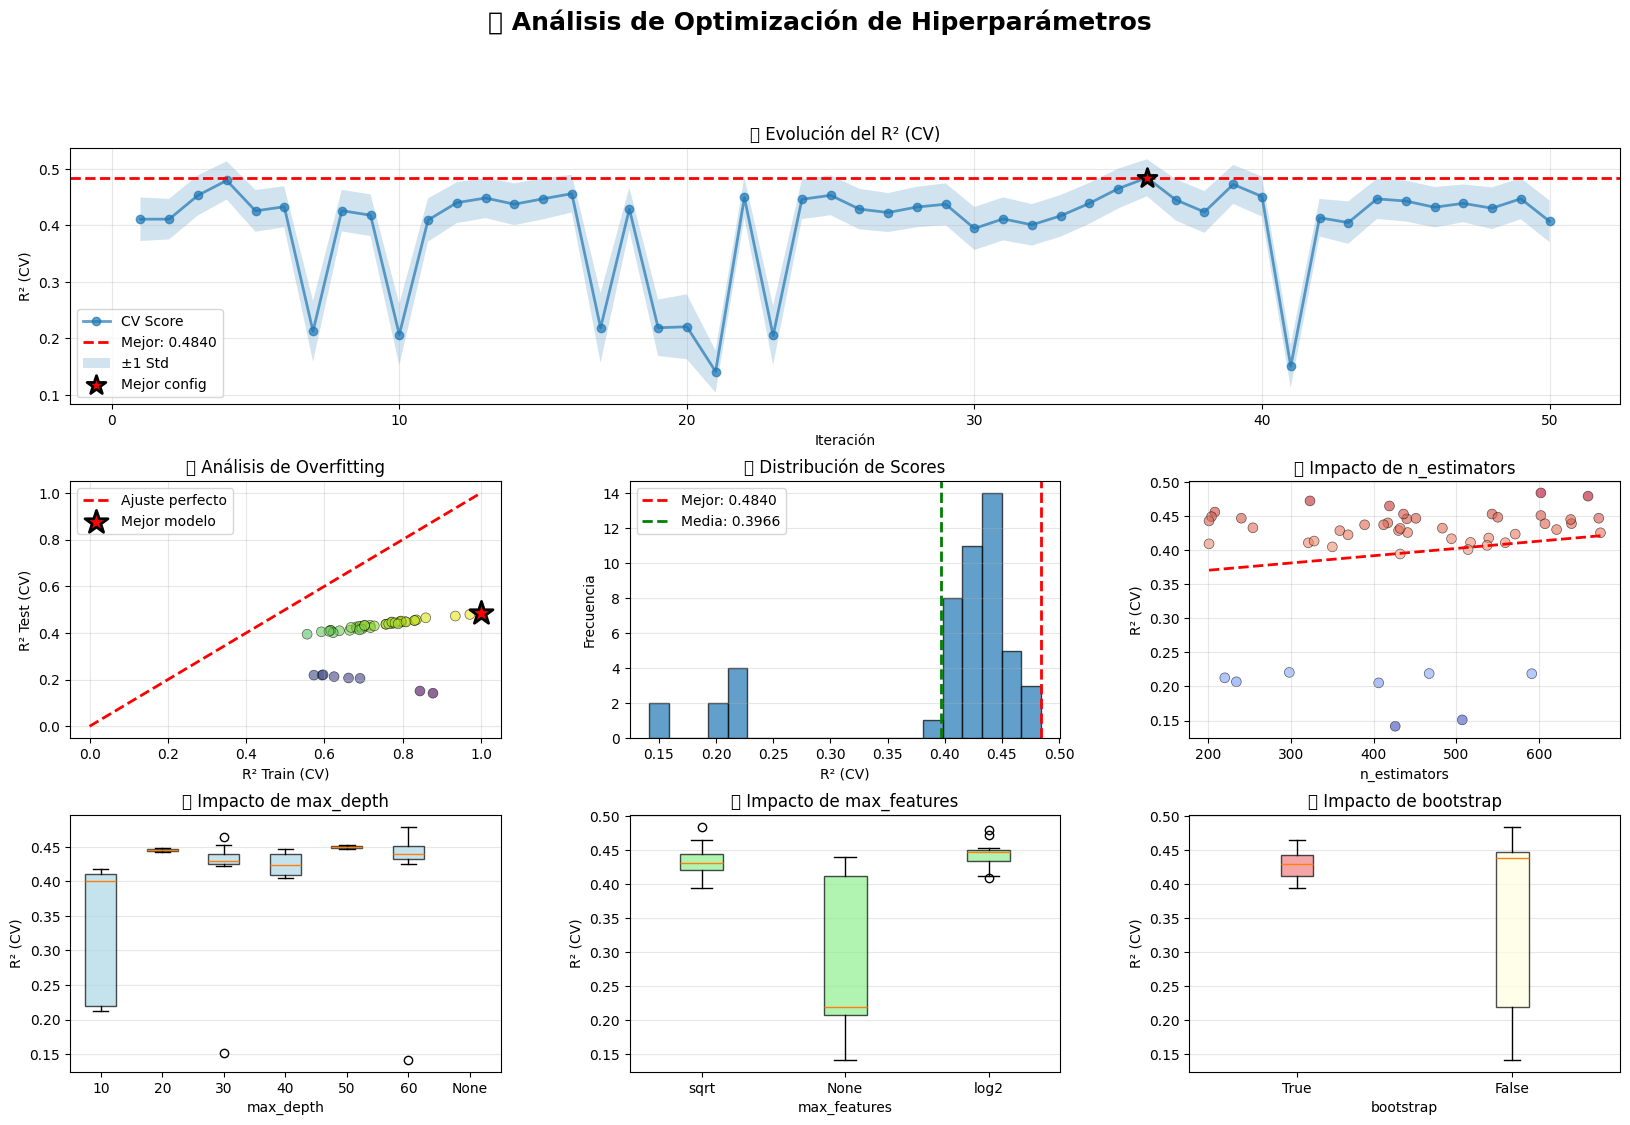


🏅 TOP 10 MEJORES CONFIGURACIONES (por mean_test_score)
 mean_test_score  std_test_score  param_n_estimators param_max_depth  param_min_samples_split  param_min_samples_leaf param_max_features  param_bootstrap  rank_test_score
        0.484009        0.032713                 602            None                        2                       1               sqrt            False                1
        0.479234        0.033863                 659              60                        2                       2               log2            False                2
        0.472317        0.034554                 323              60                       10                       1               log2            False                3
        0.464824        0.035229                 419              30                        3                       2               sqrt             True                4
        0.455873        0.033295                 208            None                     

In [11]:
# ================================================================================
# PASO 6.1: OPTIMIZACIÓN CON RANDOMIZEDSEARCHCV
# ================================================================================
#@markdown En este paso se optimizan los hiperparámetros del Random Forest mediante
#@markdown **RandomizedSearchCV (5-fold CV)**. Se reportan mejores parámetros,
#@markdown evolución de scores y análisis gráfico del espacio explorado.



print("="*80)
print("🔍 OPTIMIZACIÓN DE HIPERPARÁMETROS CON RANDOMIZEDSEARCHCV")
print("="*80)

# ------------------------------------------------------------------------------
# Baseline de referencia (si no traemos r2_test desde el PASO 5, lo calculamos aquí)
# ------------------------------------------------------------------------------
try:
    _ = r2_test  # solo para chequear existencia
    baseline_disponible = True
except NameError:
    baseline_disponible = False

if not baseline_disponible:
    rf_calibrado = RandomForestRegressor(
        n_estimators=300, max_depth=None,
        min_samples_split=2, min_samples_leaf=1,
        max_features='sqrt', random_state=42, n_jobs=-1
    )
    print("\n⏳ Entrenando baseline calibrado (referencia previa ausente)...")
    rf_calibrado.fit(X_train, y_train)
    y_test_pred_base = rf_calibrado.predict(X_test)
    y_train_pred_base = rf_calibrado.predict(X_train)

    r2_train = r2_score(y_train, y_train_pred_base)
    r2_test  = r2_score(y_test,  y_test_pred_base)
    rmse_test = mean_squared_error(y_test, y_test_pred_base, squared=False)
    mae_test  = mean_absolute_error(y_test, y_test_pred_base)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred_base)

    print("✅ Baseline calibrado entrenado (para referencia en el resumen)")
    print(f"   R² Train: {r2_train:.4f} | R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f} | MAE Test: {mae_test:.4f}")

# ------------------------------------------------------------------------------
# Espacio de búsqueda (incluye la calibración actual en el rango)
# ------------------------------------------------------------------------------
param_distributions = {
    'n_estimators': randint(200, 700),          # incluye 300
    'max_depth': [10, 20, 30, 40, 50, 60, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],     # incluye 'sqrt' (nuestra calibración)
    'bootstrap': [True, False]
}

print("\n" + "─"*80)
print("📋 ESPACIO DE BÚSQUEDA DE HIPERPARÁMETROS")
print("─"*80)
print(f"""
- n_estimators        : randint(200, 600)   → incluye 300 (calibrado)
- max_depth           : {param_distributions['max_depth']}
- min_samples_split   : randint(2, 20)
- min_samples_leaf    : randint(1, 10)
- max_features        : {param_distributions['max_features']}  (incluye 'sqrt')
- bootstrap           : {param_distributions['bootstrap']}
""")

# ------------------------------------------------------------------------------
# Configurar y ejecutar RandomizedSearchCV
# ------------------------------------------------------------------------------
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=50,                  # combinaciones a probar
    cv=5,                       # 5-fold CV
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

print("\n⏳ Iniciando búsqueda aleatoria (50 iteraciones, CV=5)...\n" + "="*80)
start_time = time.time()
random_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print("="*80)
print(f"✅ OPTIMIZACIÓN COMPLETADA en {elapsed_time/60:.2f} min ({elapsed_time:.1f} s)")

# ------------------------------------------------------------------------------
# Resultados y mejor modelo
# ------------------------------------------------------------------------------
best_params = random_search.best_params_
best_score  = random_search.best_score_
best_rf     = random_search.best_estimator_

print("\n" + "="*80)
print("🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS")
print("="*80)
for k, v in best_params.items():
    print(f"• {k:<18}: {v}")
print(f"\n📊 Mejor R² (CV): {best_score:.4f} | Ranking: {random_search.best_index_ + 1} / 50")

# ------------------------------------------------------------------------------
# Evaluación del mejor modelo en TEST
# ------------------------------------------------------------------------------
y_test_pred_opt = best_rf.predict(X_test)
y_train_pred_opt = best_rf.predict(X_train)

r2_train_opt = r2_score(y_train, y_train_pred_opt)
r2_test_opt  = r2_score(y_test,  y_test_pred_opt)
rmse_test_opt = np.sqrt(mean_squared_error(y_test, y_test_pred_opt))

mae_test_opt  = mean_absolute_error(y_test, y_test_pred_opt)
mape_test_opt = mean_absolute_percentage_error(y_test, y_test_pred_opt)

print("\n" + "="*80)
print("📊 MÉTRICAS DEL MEJOR MODELO (ENTRENADO EN TRAIN Y EVALUADO EN TEST)")
print("="*80)
print(f"{'Métrica':<18} {'Train':<12} {'Test':<12}")
print("-"*45)
print(f"{'R²':<18} {r2_train_opt:<12.4f} {r2_test_opt:<12.4f}")
print(f"{'RMSE':<18} {'-':<12} {rmse_test_opt:<12.4f}")
print(f"{'MAE':<18} {'-':<12} {mae_test_opt:<12.4f}")
print(f"{'MAPE (%)':<18} {'-':<12} {mape_test_opt*100:<12.2f}")

# ------------------------------------------------------------------------------
# Visualizaciones del proceso
# ------------------------------------------------------------------------------
cv_results = pd.DataFrame(random_search.cv_results_)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle('🔍 Análisis de Optimización de Hiperparámetros', fontsize=18, fontweight='bold', y=0.995)

# 1) Evolución de score
ax1 = fig.add_subplot(gs[0, :])
iters = np.arange(1, len(cv_results) + 1)
ax1.plot(iters, cv_results['mean_test_score'], 'o-', linewidth=2, markersize=6, alpha=0.7, label='CV Score')
ax1.axhline(y=best_score, color='red', linestyle='--', linewidth=2, label=f'Mejor: {best_score:.4f}')
ax1.fill_between(iters,
                 cv_results['mean_test_score'] - cv_results['std_test_score'],
                 cv_results['mean_test_score'] + cv_results['std_test_score'],
                 alpha=0.2, label='±1 Std')
ax1.scatter(random_search.best_index_ + 1, best_score, color='red', s=200, marker='*',
            zorder=5, edgecolors='black', linewidths=2, label='Mejor config')
ax1.set_title('📊 Evolución del R² (CV)')
ax1.set_xlabel('Iteración'); ax1.set_ylabel('R² (CV)'); ax1.legend(); ax1.grid(True, alpha=0.3)

# 2) Overfitting: Train vs Test (CV)
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(cv_results['mean_train_score'], cv_results['mean_test_score'],
            c=cv_results['mean_test_score'], cmap='viridis', s=50, alpha=0.6,
            edgecolors='black', linewidth=0.5)
ax2.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Ajuste perfecto')
ax2.scatter(cv_results.iloc[random_search.best_index_]['mean_train_score'],
            cv_results.iloc[random_search.best_index_]['mean_test_score'],
            color='red', s=300, marker='*', zorder=5,
            edgecolors='black', linewidths=2, label='Mejor modelo')
ax2.set_title('🎯 Análisis de Overfitting')
ax2.set_xlabel('R² Train (CV)'); ax2.set_ylabel('R² Test (CV)'); ax2.legend(); ax2.grid(True, alpha=0.3)

# 3) Distribución de scores
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(cv_results['mean_test_score'], bins=20, edgecolor='black', alpha=0.7)
ax3.axvline(best_score, color='red', linestyle='--', linewidth=2, label=f'Mejor: {best_score:.4f}')
ax3.axvline(cv_results['mean_test_score'].mean(), color='green', linestyle='--', linewidth=2,
            label=f"Media: {cv_results['mean_test_score'].mean():.4f}")
ax3.set_title('📊 Distribución de Scores'); ax3.set_xlabel('R² (CV)'); ax3.set_ylabel('Frecuencia')
ax3.legend(); ax3.grid(True, alpha=0.3, axis='y')

# 4) Impacto de n_estimators
ax4 = fig.add_subplot(gs[1, 2])
param_n = cv_results['param_n_estimators'].astype(int)
ax4.scatter(param_n, cv_results['mean_test_score'], c=cv_results['mean_test_score'],
            cmap='coolwarm', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax4.set_title('🌳 Impacto de n_estimators'); ax4.set_xlabel('n_estimators'); ax4.set_ylabel('R² (CV)')
coef = np.polyfit(param_n, cv_results['mean_test_score'], 1)
ax4.plot(sorted(param_n), np.poly1d(coef)(sorted(param_n)), "r--", linewidth=2); ax4.grid(True, alpha=0.3)

# 5) Impacto de max_depth
ax5 = fig.add_subplot(gs[2, 0])
param_md = cv_results['param_max_depth'].apply(lambda x: 50 if x is None else int(x))
labels_md = ['10','20','30','40', '50', '60','None']
data_md = [cv_results[cv_results['param_max_depth']==d]['mean_test_score'].values for d in [10,20,30,40,50,60,None]]
bp = ax5.boxplot(data_md, labels=labels_md, patch_artist=True)
for b in bp['boxes']: b.set_facecolor('lightblue'); b.set_alpha(0.7)
ax5.set_title('📏 Impacto de max_depth'); ax5.set_xlabel('max_depth'); ax5.set_ylabel('R² (CV)')
ax5.grid(True, alpha=0.3, axis='y')

# 6) Impacto de max_features
ax6 = fig.add_subplot(gs[2, 1])
param_mf = cv_results['param_max_features'].astype(str)
unique_mf = list(param_mf.unique())
data_mf = [cv_results[param_mf == mf]['mean_test_score'].values for mf in unique_mf]
bp2 = ax6.boxplot(data_mf, labels=unique_mf, patch_artist=True)
for b in bp2['boxes']: b.set_facecolor('lightgreen'); b.set_alpha(0.7)
ax6.set_title('🎲 Impacto de max_features'); ax6.set_xlabel('max_features'); ax6.set_ylabel('R² (CV)')
ax6.grid(True, alpha=0.3, axis='y')

# 7) Impacto de bootstrap
ax7 = fig.add_subplot(gs[2, 2])
param_bs = cv_results['param_bootstrap'].astype(bool)
data_bs = [cv_results[param_bs == True]['mean_test_score'].values,
           cv_results[param_bs == False]['mean_test_score'].values]
bp3 = ax7.boxplot(data_bs, labels=['True','False'], patch_artist=True)
bp3['boxes'][0].set_facecolor('lightcoral'); bp3['boxes'][1].set_facecolor('lightyellow')
for b in bp3['boxes']: b.set_alpha(0.7)
ax7.set_title('🎒 Impacto de bootstrap'); ax7.set_xlabel('bootstrap'); ax7.set_ylabel('R² (CV)')
ax7.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# Top-10 configuraciones
# ------------------------------------------------------------------------------
print("\n" + "="*80)
print("🏅 TOP 10 MEJORES CONFIGURACIONES (por mean_test_score)")
print("="*80)
top_10 = cv_results.nlargest(10, 'mean_test_score')[
    ['mean_test_score','std_test_score',
     'param_n_estimators','param_max_depth','param_min_samples_split',
     'param_min_samples_leaf','param_max_features','param_bootstrap','rank_test_score']
]
print(top_10.to_string(index=False))

# ------------------------------------------------------------------------------
# Resumen ejecutivo
# ------------------------------------------------------------------------------
print("\n" + "="*80)
print("📋 RESUMEN EJECUTIVO DE LA OPTIMIZACIÓN")
print("="*80)
mejora_pct = ((best_score - r2_test) / r2_test * 100) if r2_test != 0 else np.nan
print(f"""
⏱️  Tiempo total: {elapsed_time/60:.2f} min  |  Por iteración: {elapsed_time/50:.1f} s
🎯 Baseline R² Test (calibrado): {r2_test:.4f}
🎯 Mejor R² (CV - Random Search): {best_score:.4f}
📈 Mejora relativa vs baseline: {mejora_pct:+.2f}%

🧪 Test del mejor modelo:
   • R² Test  : {r2_test_opt:.4f}
   • RMSE Test: {rmse_test_opt:.4f}
   • MAE  Test: {mae_test_opt:.4f}
   • MAPE Test: {mape_test_opt*100:.2f}%
""")

print("✅ Análisis de optimización completado.\n")


🔄 VALIDACIÓN CRUZADA (5-FOLD CROSS-VALIDATION)
✅ Usando el modelo best_rf obtenido en la optimización.

⏳ Ejecutando validación cruzada (K=5)...

✅ Validación cruzada completada en 14.5 s

────────────────────────────────────────────────────────────────────────────────
📈 TABLA DE RESULTADOS
────────────────────────────────────────────────────────────────────────────────

Métrica                        Media           Std             Min             Max            
──────────────────────────────────────────────────────────────────────────────────────────
R² Score                       0.4733          0.0348          0.4245          0.5226         
RMSE                           0.6364          0.0299          0.6023          0.6795         
MAE                            0.4622          0.0165          0.4478          0.4899         

────────────────────────────────────────────────────────────────────────────────
📊 SCORES POR FOLD (DETALLE)
─────────────────────────────────────────────

C:\Users\juanc\AppData\Local\Temp\ipykernel_46564\3581740312.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


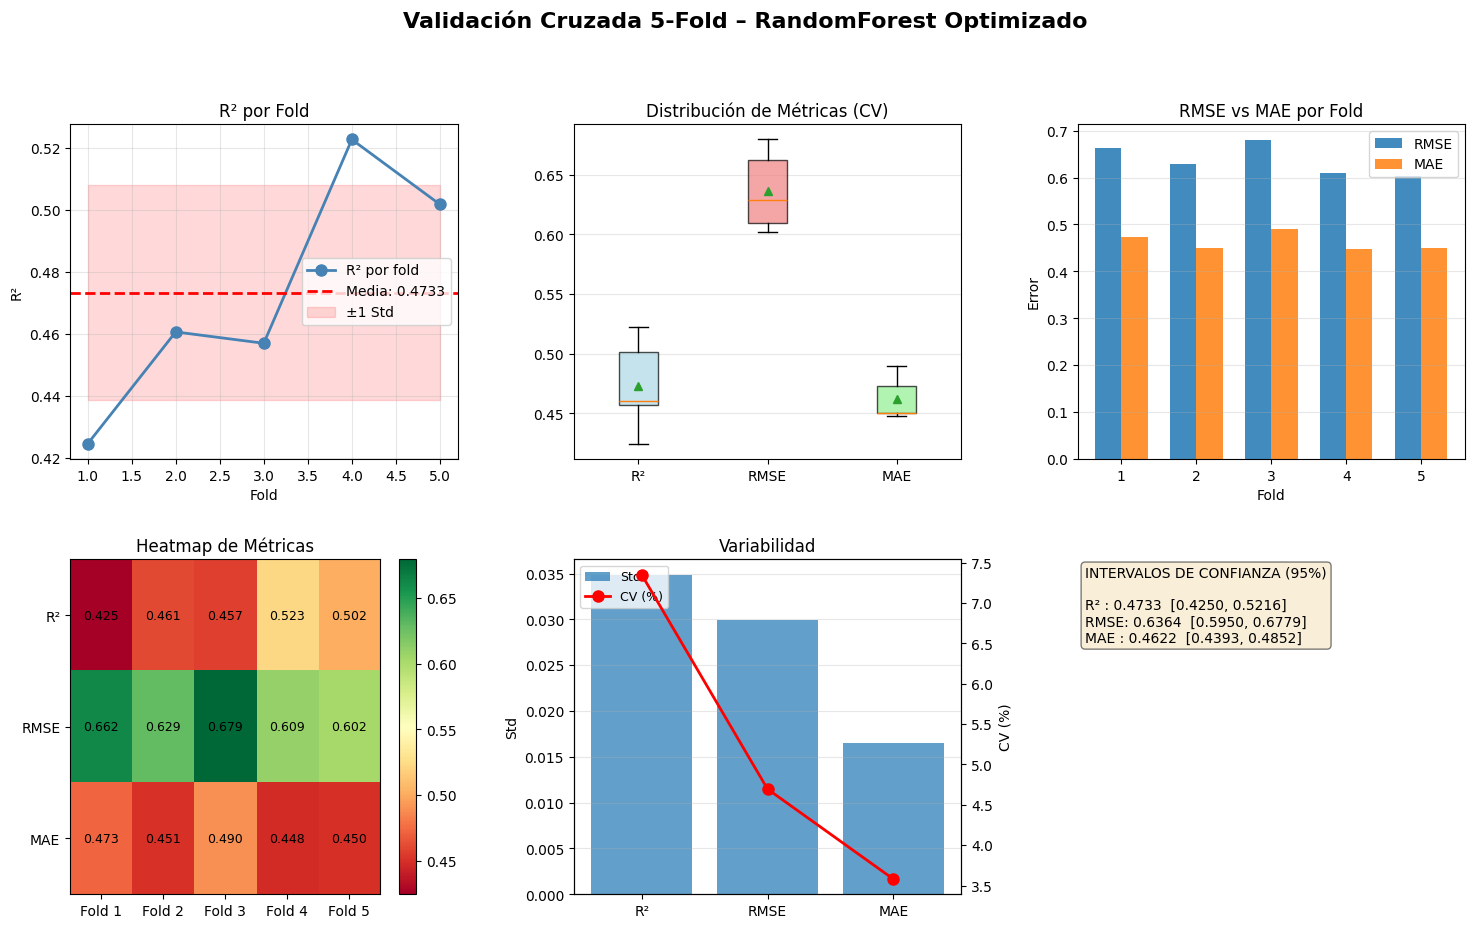


📋 RESUMEN EJECUTIVO DE VALIDACIÓN CRUZADA

R² (CV mean ± std): 0.4733 ± 0.0348
RMSE (CV)          : 0.6364 ± 0.0299
MAE  (CV)          : 0.4622 ± 0.0165

Coef. variación  R²: 7.35%   |  RMSE: 4.70%   |  MAE: 3.58%
Relación RMSE/MAE  : 1.38

✅ Validación cruzada completada.



In [28]:
# ================================================================================
# PASO 8: VALIDACIÓN CRUZADA (CROSS-VALIDATION)
# ================================================================================
#@markdown Validamos con 5-fold CV el mejor RandomForest (best_rf). Si no existe,
#@markdown se recrea con los hiperparámetros óptimos del Random Search.


print("="*80)
print("🔄 VALIDACIÓN CRUZADA (5-FOLD CROSS-VALIDATION)")
print("="*80)

# ---------------------------
# 0) Asegurar modelo óptimo
# ---------------------------
try:
    best_rf
    print("✅ Usando el modelo best_rf obtenido en la optimización.")
except NameError:
    print("ℹ️ best_rf no existe en memoria. Se construye con los mejores hiperparámetros encontrados.")
    best_rf = RandomForestRegressor(
        bootstrap=False,
        max_depth=40,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=9,
        n_estimators=327,
        random_state=42,
        n_jobs=-1
    )
    best_rf.fit(X_train, y_train)

# ---------------------------
# 1) Ejecutar CV con métricas
# ---------------------------
print("\n⏳ Ejecutando validación cruzada (K=5)...\n")
start = time.time()

# R2
r2_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

# Neg MSE -> RMSE
mse_scores_neg = cross_val_score(best_rf, X_train, y_train, cv=5,
                                 scoring='neg_mean_squared_error', n_jobs=-1)
rmse_scores = np.sqrt(-mse_scores_neg)

# Neg MAE -> MAE
mae_scores = -cross_val_score(best_rf, X_train, y_train, cv=5,
                              scoring='neg_mean_absolute_error', n_jobs=-1)

elapsed = time.time() - start
print(f"✅ Validación cruzada completada en {elapsed:.1f} s")

# ---------------------------
# 2) Tabla de resultados
# ---------------------------
print("\n" + "─"*80)
print("📈 TABLA DE RESULTADOS")
print("─"*80)
print(f"\n{'Métrica':<30} {'Media':<15} {'Std':<15} {'Min':<15} {'Max':<15}")
print("─"*90)
print(f"{'R² Score':<30} {r2_scores.mean():<15.4f} {r2_scores.std():<15.4f} {r2_scores.min():<15.4f} {r2_scores.max():<15.4f}")
print(f"{'RMSE':<30} {rmse_scores.mean():<15.4f} {rmse_scores.std():<15.4f} {rmse_scores.min():<15.4f} {rmse_scores.max():<15.4f}")
print(f"{'MAE':<30} {mae_scores.mean():<15.4f} {mae_scores.std():<15.4f} {mae_scores.min():<15.4f} {mae_scores.max():<15.4f}")

fold_results = pd.DataFrame({
    'Fold': np.arange(1, 6),
    'R²': r2_scores,
    'RMSE': rmse_scores,
    'MAE': mae_scores
})
print("\n" + "─"*80)
print("📊 SCORES POR FOLD (DETALLE)")
print("─"*80)
print("\n" + fold_results.to_string(index=False))

# ---------------------------
# 3) Visualizaciones (6)
# ---------------------------
print("\n" + "="*80)
print("📊 GENERANDO VISUALIZACIONES DE VALIDACIÓN CRUZADA")
print("="*80)

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
fig.suptitle('Validación Cruzada 5-Fold – RandomForest Optimizado',
             fontsize=16, fontweight='bold', y=0.995)

folds = np.arange(1, 6)

# (1) R2 por fold
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(folds, r2_scores, 'o-', linewidth=2, markersize=8, color='steelblue', label='R² por fold')
ax1.axhline(y=r2_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {r2_scores.mean():.4f}')
ax1.fill_between(folds, r2_scores.mean()-r2_scores.std(), r2_scores.mean()+r2_scores.std(),
                 alpha=0.15, color='red', label='±1 Std')
ax1.set_title('R² por Fold'); ax1.set_xlabel('Fold'); ax1.set_ylabel('R²'); ax1.legend(); ax1.grid(True, alpha=0.3)

# (2) Boxplots de métricas
ax2 = fig.add_subplot(gs[0, 1])
bp = ax2.boxplot([r2_scores, rmse_scores, mae_scores],
                 tick_labels=['R²','RMSE','MAE'],
                 patch_artist=True, showmeans=True)
for box, c in zip(bp['boxes'], ['lightblue','lightcoral','lightgreen']):
    box.set_facecolor(c); box.set_alpha(0.7)
ax2.set_title('Distribución de Métricas (CV)'); ax2.grid(True, alpha=0.3, axis='y')

# (3) Barras RMSE vs MAE por fold
ax3 = fig.add_subplot(gs[0, 2])
x = np.arange(len(folds)); width = 0.35
ax3.bar(x - width/2, rmse_scores, width, label='RMSE', alpha=0.85)
ax3.bar(x + width/2, mae_scores,  width, label='MAE',  alpha=0.85)
ax3.set_xticks(x); ax3.set_xticklabels(folds)
ax3.set_title('RMSE vs MAE por Fold'); ax3.set_xlabel('Fold'); ax3.set_ylabel('Error')
ax3.legend(); ax3.grid(True, alpha=0.3, axis='y')

# (4) Heatmap simple
ax4 = fig.add_subplot(gs[1, 0])
matrix = np.vstack([r2_scores, rmse_scores, mae_scores])
im = ax4.imshow(matrix, cmap='RdYlGn', aspect='auto')
ax4.set_yticks([0,1,2]); ax4.set_yticklabels(['R²','RMSE','MAE'])
ax4.set_xticks(range(5)); ax4.set_xticklabels([f'Fold {i}' for i in folds])
ax4.set_title('Heatmap de Métricas'); plt.colorbar(im, ax=ax4)
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax4.text(j, i, f'{matrix[i, j]:.3f}', ha='center', va='center', fontsize=9)

# (5) Variabilidad (std y CV%)
ax5 = fig.add_subplot(gs[1, 1])
std_vals = [r2_scores.std(), rmse_scores.std(), mae_scores.std()]
cv_vals  = [
    (r2_scores.std()/r2_scores.mean())*100 if r2_scores.mean()!=0 else np.nan,
    (rmse_scores.std()/rmse_scores.mean())*100 if rmse_scores.mean()!=0 else np.nan,
    (mae_scores.std()/mae_scores.mean())*100 if mae_scores.mean()!=0 else np.nan
]
ax5b = ax5.twinx()
ax5.bar(['R²','RMSE','MAE'], std_vals, alpha=0.7, label='Std')
ax5b.plot(['R²','RMSE','MAE'], cv_vals, 'ro-', linewidth=2, markersize=8, label='CV (%)')
ax5.set_ylabel('Std'); ax5b.set_ylabel('CV (%)'); ax5.set_title('Variabilidad'); ax5.grid(True, alpha=0.3, axis='y')
# leyenda combinada
h1,l1 = ax5.get_legend_handles_labels(); h2,l2 = ax5b.get_legend_handles_labels()
ax5.legend(h1+h2, l1+l2, loc='upper left', fontsize=9)

# (6) Intervalos de confianza 95% (texto)
from scipy import stats as st
def ci95(x):
    n=len(x); m=np.mean(x); se=st.sem(x); h=se*st.t.ppf(0.975, n-1); return m, m-h, m+h
r2_m, r2_l, r2_u = ci95(r2_scores)
rmse_m, rmse_l, rmse_u = ci95(rmse_scores)
mae_m, mae_l, mae_u = ci95(mae_scores)

ax6 = fig.add_subplot(gs[1, 2]); ax6.axis('off')
ax6.text(0.02, 0.98, 
         (f"INTERVALOS DE CONFIANZA (95%)\n\n"
          f"R² : {r2_m:.4f}  [{r2_l:.4f}, {r2_u:.4f}]\n"
          f"RMSE: {rmse_m:.4f}  [{rmse_l:.4f}, {rmse_u:.4f}]\n"
          f"MAE : {mae_m:.4f}  [{mae_l:.4f}, {mae_u:.4f}]"),
         va='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# ---------------------------
# 4) Resumen ejecutivo
# ---------------------------
cv_r2  = (r2_scores.std()/r2_scores.mean())*100 if r2_scores.mean()!=0 else np.nan
cv_rmse= (rmse_scores.std()/rmse_scores.mean())*100 if rmse_scores.mean()!=0 else np.nan
cv_mae = (mae_scores.std()/mae_scores.mean())*100 if mae_scores.mean()!=0 else np.nan
rmse_mae_ratio = rmse_scores.mean()/mae_scores.mean()

print("\n" + "="*80)
print("📋 RESUMEN EJECUTIVO DE VALIDACIÓN CRUZADA")
print("="*80)
print(f"""
R² (CV mean ± std): {r2_scores.mean():.4f} ± {r2_scores.std():.4f}
RMSE (CV)          : {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}
MAE  (CV)          : {mae_scores.mean():.4f} ± {mae_scores.std():.4f}

Coef. variación  R²: {cv_r2:.2f}%   |  RMSE: {cv_rmse:.2f}%   |  MAE: {cv_mae:.2f}%
Relación RMSE/MAE  : {rmse_mae_ratio:.2f}
""")
print("✅ Validación cruzada completada.\n")


🔍 ANÁLISIS COMPLETO DE IMPORTANCIA DE CARACTERÍSTICAS
📌 Modelo usado para el análisis: best_rf

────────────────────────────────────────────────────────────────────────────────
📊 RANKING DE IMPORTANCIA MDI (ENTRENAMIENTO)
────────────────────────────────────────────────────────────────────────────────

Rank   Feature                   Importancia  Acumulado % 
------------------------------------------------------------
1      alcohol                   0.1907       19.07       
2      density                   0.1190       30.97       
3      volatile acidity          0.1165       42.61       
4      free sulfur dioxide       0.0955       52.16       
5      chlorides                 0.0900       61.16       
6      residual sugar            0.0811       69.27       
7      sulphates                 0.0808       77.35       
8      citric acid               0.0804       85.39       
9      pH                        0.0783       93.22       
10     fixed acidity             0.0678      

C:\Users\juanc\AppData\Local\Temp\ipykernel_29612\2353072029.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\juanc\OneDrive\Documentos\GitHub\ml-tarea1-vinos\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\juanc\OneDrive\Documentos\GitHub\ml-tarea1-vinos\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\juanc\OneDrive\Documentos\GitHub\ml-tarea1-vinos\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\juanc\OneDrive\Documentos\GitHub\ml-tarea1-vinos\.venv\L

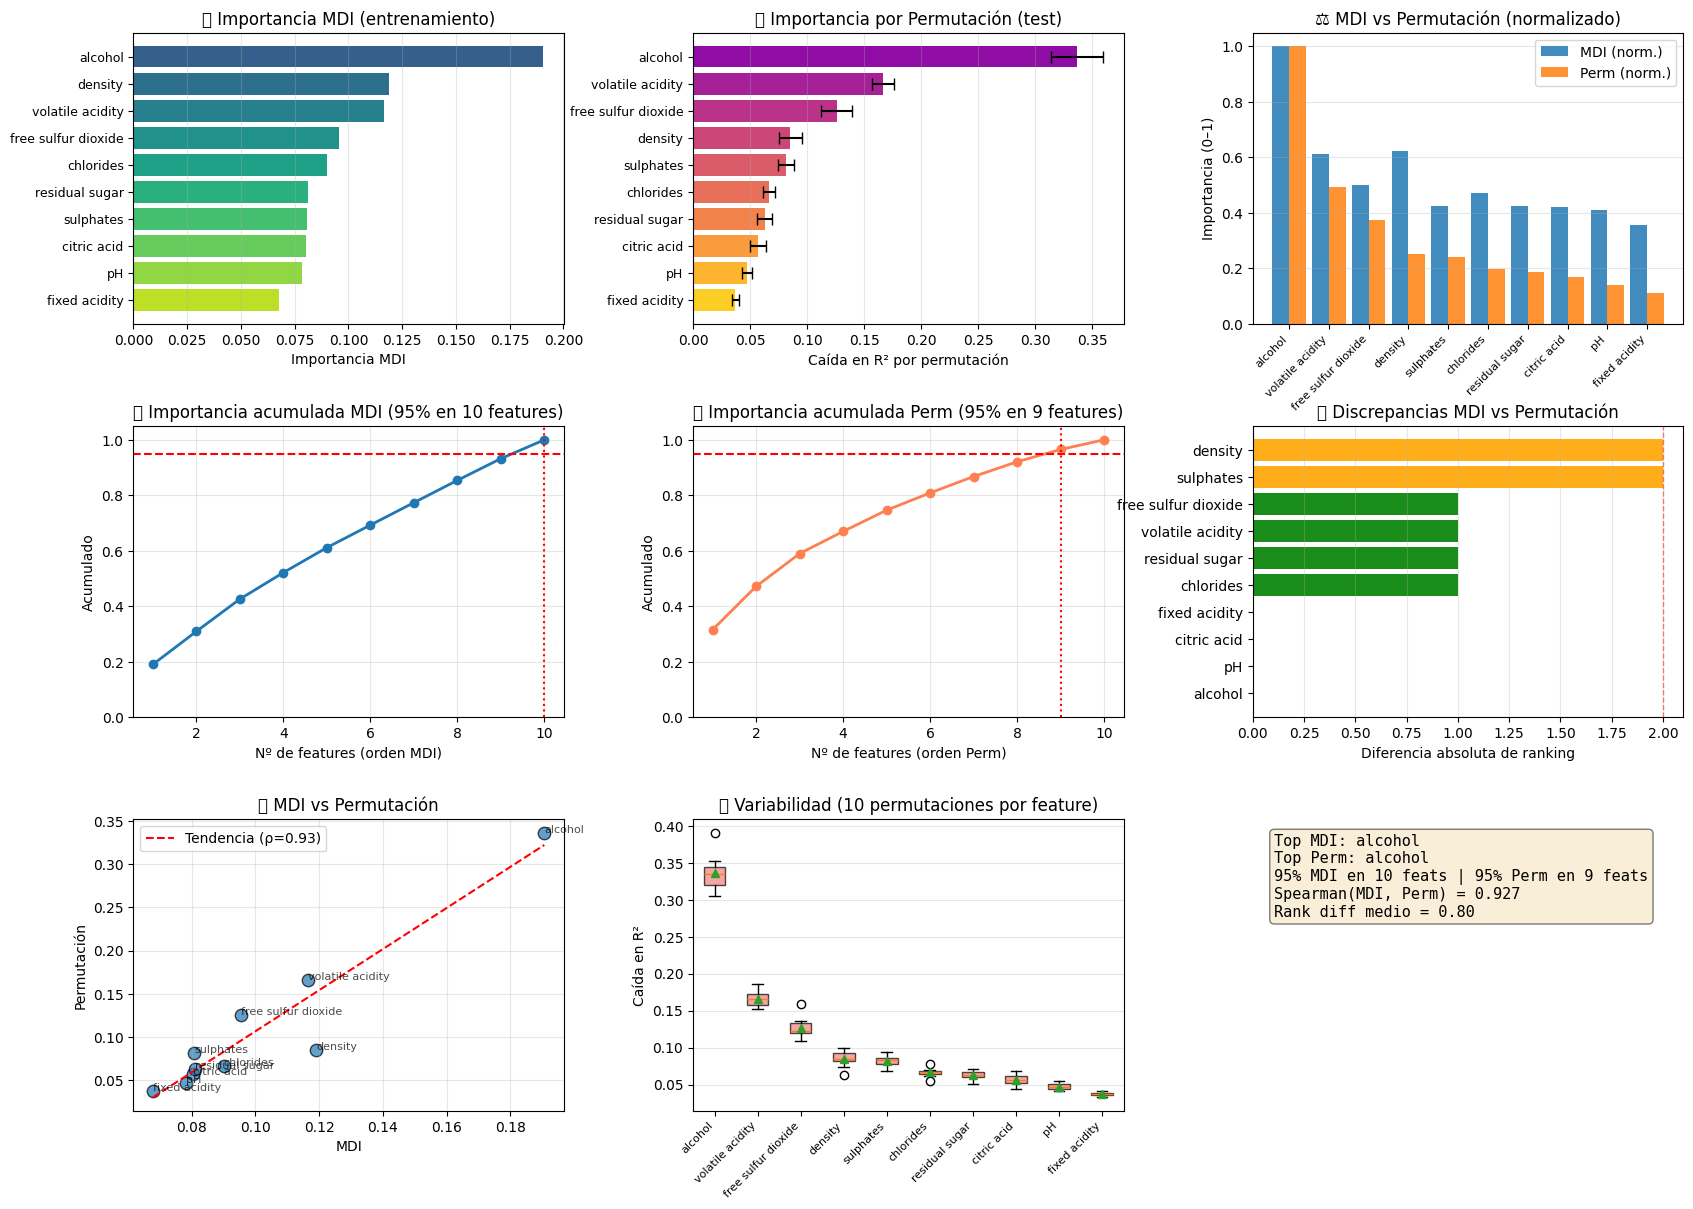


🎯 RECOMENDACIONES DE SELECCIÓN DE FEATURES
• Enfoque conservador (95% Perm): 9 features → ['alcohol', 'volatile acidity', 'free sulfur dioxide', 'density', 'sulphates', 'chlorides', 'residual sugar', 'citric acid', 'pH']
• Enfoque moderado (Top-5 Perm): ['alcohol', 'volatile acidity', 'free sulfur dioxide', 'density', 'sulphates']
• Enfoque agresivo (Top-3 Perm): ['alcohol', 'volatile acidity', 'free sulfur dioxide']

✅ Sugerencia: reentrena con cada set y compara R²/RMSE/MAE. Si la pérdida < 5%, adopta el set reducido.


In [28]:
# ================================================================================
# PASO 9: ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS (MDI vs PERMUTACIÓN)
# ================================================================================

print("="*80)
print("🔍 ANÁLISIS COMPLETO DE IMPORTANCIA DE CARACTERÍSTICAS")
print("="*80)

# ------------------------------------------------------------------------------
# 0) Seleccionar el modelo a analizar
# ------------------------------------------------------------------------------
modelo = None
for cand in ["best_rf"]:
    if cand in globals():
        modelo = globals()[cand]
        print(f"📌 Modelo usado para el análisis: {cand}")
        break
if modelo is None:
    raise RuntimeError("No se encontró un modelo entrenado (rf_calibrado).")

# Verificaciones mínimas
assert hasattr(modelo, "predict"), "El objeto seleccionado no es un estimador válido."
assert X_train.shape[1] == X_test.shape[1], "X_train y X_test no tienen el mismo número de columnas."

feature_names = np.array(getattr(X_train, "columns", [f"f{i}" for i in range(X_train.shape[1])]), dtype=object)

# ------------------------------------------------------------------------------
# 1) MDI (Mean Decrease in Impurity) - importances_ del modelo
# ------------------------------------------------------------------------------
if not hasattr(modelo, "feature_importances_"):
    raise RuntimeError("El modelo no expone 'feature_importances_' (¿no es árbol/ensamble de árboles?).")

importances_mdi = modelo.feature_importances_.astype(float)
indices_mdi = np.argsort(importances_mdi)[::-1]

# métricas acumuladas
cumulative_importances_mdi = np.cumsum(importances_mdi[indices_mdi])
n_features_95_mdi = int(np.argmax(cumulative_importances_mdi >= 0.95) + 1)

print("\n" + "─"*80)
print("📊 RANKING DE IMPORTANCIA MDI (ENTRENAMIENTO)")
print("─"*80)
print(f"\n{'Rank':<6} {'Feature':<25} {'Importancia':<12} {'Acumulado %':<12}")
print("-"*60)
cum = 0.0
for rk, idx in enumerate(indices_mdi, 1):
    cum += importances_mdi[idx]
    print(f"{rk:<6} {feature_names[idx]:<25} {importances_mdi[idx]:<12.4f} {cum*100:<12.2f}")

print(f"\n💡 INSIGHTS MDI:\n   • Top-1: {feature_names[indices_mdi[0]]} ({importances_mdi[indices_mdi[0]]:.4f})"
      f"\n   • {n_features_95_mdi} features explican el 95% de la importancia")

# ------------------------------------------------------------------------------
# 2) Permutation Importance (en TEST, scoring=R²)
# ------------------------------------------------------------------------------
print("\n⏳ Calculando importancia por permutación en TEST (10 repeticiones, R²)...")
perm = permutation_importance(
    modelo, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1, scoring="r2"
)
importances_perm = perm.importances_mean
importances_perm_std = perm.importances_std
indices_perm = np.argsort(importances_perm)[::-1]

total_imp_perm = importances_perm.sum() if importances_perm.sum() != 0 else 1.0
cumulative_importances_perm = np.cumsum(importances_perm[indices_perm])
n_features_95_perm = int(np.argmax(cumulative_importances_perm >= 0.95*total_imp_perm) + 1)

print("✅ Importancia por permutación calculada.\n")
print("─"*80)
print("📊 RANKING DE IMPORTANCIA POR PERMUTACIÓN (IMPACTO EN R²)")
print("─"*80)
print(f"\n{'Rank':<6} {'Feature':<25} {'Importancia':<12} {'Std':<10} {'Acum %':<10}")
print("-"*70)
cum = 0.0
for rk, idx in enumerate(indices_perm, 1):
    v = importances_perm[idx]; s = importances_perm_std[idx]
    cum += v
    print(f"{rk:<6} {feature_names[idx]:<25} {v:<12.4f} {s:<10.4f} {(cum/total_imp_perm)*100:<10.2f}")

print(f"\n💡 INSIGHTS PERMUTACIÓN:\n   • Top-1: {feature_names[indices_perm[0]]} ({importances_perm[indices_perm[0]]:.4f} ± {importances_perm_std[indices_perm[0]]:.4f})"
      f"\n   • {n_features_95_perm} features alcanzan ~95% de importancia acumulada (perm.)")

# ------------------------------------------------------------------------------
# 3) Comparación: MDI vs Permutation
# ------------------------------------------------------------------------------
mdi_rank_pos = np.empty_like(indices_mdi)
mdi_rank_pos[indices_mdi] = np.arange(len(indices_mdi))
perm_rank_pos = np.empty_like(indices_perm)
perm_rank_pos[indices_perm] = np.arange(len(indices_perm))
rank_diff = np.abs(mdi_rank_pos - perm_rank_pos)

comparison_df = pd.DataFrame({
    "Feature": feature_names,
    "MDI": importances_mdi,
    "Permutation": importances_perm,
    "MDI_Rank": mdi_rank_pos + 1,
    "Perm_Rank": perm_rank_pos + 1,
    "Rank_Diff": rank_diff
}).sort_values("Permutation", ascending=False)

spearman_corr = sp_stats.spearmanr(importances_mdi, importances_perm, nan_policy="omit").correlation
print("\n" + "="*80)
print("⚖️  COMPARACIÓN MDI vs PERMUTACIÓN")
print("="*80)
print(f"• Correlación Spearman (importancias): {spearman_corr:.3f}")
print(f"• Diferencia promedio de ranking: {rank_diff.mean():.2f} posiciones")
print("\n📋 Tabla comparativa (ordenada por Permutación):")
print(comparison_df.to_string(index=False))

# ------------------------------------------------------------------------------
# 4) Visualizaciones clave
# ------------------------------------------------------------------------------
plt.figure(figsize=(20, 14))
gs = plt.GridSpec(3, 3, hspace=0.35, wspace=0.3)

# (1) Barras MDI
ax1 = plt.subplot(gs[0,0])
vals = importances_mdi[indices_mdi]
ax1.barh(range(len(vals)), vals, color=plt.cm.viridis(np.linspace(0.3,0.9,len(vals))))
ax1.set_yticks(range(len(vals)))
ax1.set_yticklabels(feature_names[indices_mdi], fontsize=9)
ax1.invert_yaxis()
ax1.set_xlabel("Importancia MDI")
ax1.set_title("📊 Importancia MDI (entrenamiento)")
ax1.grid(True, axis='x', alpha=0.3)

# (2) Barras Perm + error
ax2 = plt.subplot(gs[0,1])
vals_p = importances_perm[indices_perm]
errs_p = importances_perm_std[indices_perm]
ax2.barh(range(len(vals_p)), vals_p, xerr=errs_p, capsize=4,
         color=plt.cm.plasma(np.linspace(0.3,0.9,len(vals_p))))
ax2.set_yticks(range(len(vals_p)))
ax2.set_yticklabels(feature_names[indices_perm], fontsize=9)
ax2.invert_yaxis()
ax2.set_xlabel("Caída en R² por permutación")
ax2.set_title("📊 Importancia por Permutación (test)")
ax2.grid(True, axis='x', alpha=0.3)

# (3) Comparación normalizada
ax3 = plt.subplot(gs[0,2])
mdi_norm  = importances_mdi / (importances_mdi.max()  if importances_mdi.max()  else 1)
perm_norm = importances_perm / (importances_perm.max() if importances_perm.max() else 1)
x = np.arange(len(feature_names))
width = 0.42
# ordenar por Permutación
order = indices_perm
ax3.bar(x - width/2, mdi_norm[order],  width, label="MDI (norm.)",  alpha=0.85)
ax3.bar(x + width/2, perm_norm[order], width, label="Perm (norm.)", alpha=0.85)
ax3.set_xticks(x); ax3.set_xticklabels(feature_names[order], rotation=45, ha='right', fontsize=8)
ax3.set_title("⚖️ MDI vs Permutación (normalizado)")
ax3.set_ylabel("Importancia (0–1)")
ax3.legend(); ax3.grid(True, axis='y', alpha=0.3)

# (4) Acumulada MDI
ax4 = plt.subplot(gs[1,0])
ax4.plot(np.arange(1,len(vals)+1), np.cumsum(vals), "o-", lw=2)
ax4.axhline(0.95, color="red", ls="--", lw=1.5)
ax4.axvline(n_features_95_mdi, color="red", ls=":", lw=1.5)
ax4.set_ylim(0, 1.05)
ax4.set_title(f"📈 Importancia acumulada MDI (95% en {n_features_95_mdi} features)")
ax4.set_xlabel("Nº de features (orden MDI)")
ax4.set_ylabel("Acumulado"); ax4.grid(True, alpha=0.3)

# (5) Acumulada Perm
ax5 = plt.subplot(gs[1,1])
perm_acc = np.cumsum(vals_p)
perm_acc_norm = perm_acc / (perm_acc[-1] if perm_acc[-1] else 1)
ax5.plot(np.arange(1,len(vals_p)+1), perm_acc_norm, "o-", lw=2, color="coral")
ax5.axhline(0.95, color="red", ls="--", lw=1.5)
ax5.axvline(n_features_95_perm, color="red", ls=":", lw=1.5)
ax5.set_ylim(0, 1.05)
ax5.set_title(f"📈 Importancia acumulada Perm (95% en {n_features_95_perm} features)")
ax5.set_xlabel("Nº de features (orden Perm)")
ax5.set_ylabel("Acumulado"); ax5.grid(True, alpha=0.3)

# (6) Discrepancias de ranking
ax6 = plt.subplot(gs[1,2])
rank_diff_series = pd.Series(rank_diff, index=feature_names).sort_values(ascending=False)
colors = ["red" if d>2 else "orange" if d>1 else "green" for d in rank_diff_series.values]
ax6.barh(rank_diff_series.index, rank_diff_series.values, color=colors, alpha=0.9)
ax6.invert_yaxis()
ax6.set_xlabel("Diferencia absoluta de ranking")
ax6.set_title("📊 Discrepancias MDI vs Permutación")
ax6.axvline(2, color="red", ls="--", lw=1, alpha=0.5)
ax6.grid(True, axis='x', alpha=0.3)

# (7) Dispersión MDI vs Perm (correlación)
ax7 = plt.subplot(gs[2,0])
ax7.scatter(importances_mdi, importances_perm, s=80, edgecolors='k', alpha=0.7)
# recta de tendencia
z = np.polyfit(importances_mdi, importances_perm, 1)
p = np.poly1d(z)
xline = np.linspace(importances_mdi.min(), importances_mdi.max(), 100)
ax7.plot(xline, p(xline), "r--", lw=1.5, label=f"Tendencia (ρ={spearman_corr:.2f})")
for i, f in enumerate(feature_names):
    ax7.annotate(f, (importances_mdi[i], importances_perm[i]), fontsize=8, alpha=0.7)
ax7.set_xlabel("MDI"); ax7.set_ylabel("Permutación")
ax7.set_title("🔍 MDI vs Permutación"); ax7.legend(); ax7.grid(True, alpha=0.3)

# (8) Boxplots de variabilidad de permutación
ax8 = plt.subplot(gs[2,1])
perm_all = perm.importances  # shape: (n_features, n_repeats)
ordered_perm_all = [perm_all[i] for i in indices_perm]
bp = ax8.boxplot(ordered_perm_all, tick_labels=feature_names[indices_perm], patch_artist=True, showmeans=True)
for b in bp['boxes']: b.set(facecolor="lightcoral", alpha=0.7)
ax8.set_title("📦 Variabilidad (10 permutaciones por feature)")
ax8.set_xticklabels(feature_names[indices_perm], rotation=45, ha='right', fontsize=8)
ax8.set_ylabel("Caída en R²"); ax8.grid(True, axis='y', alpha=0.3)

# (9) Resumen
ax9 = plt.subplot(gs[2,2]); ax9.axis("off")
summary = (f"Top MDI: {feature_names[indices_mdi[0]]}\n"
           f"Top Perm: {feature_names[indices_perm[0]]}\n"
           f"95% MDI en {n_features_95_mdi} feats | 95% Perm en {n_features_95_perm} feats\n"
           f"Spearman(MDI, Perm) = {spearman_corr:.3f}\n"
           f"Rank diff medio = {rank_diff.mean():.2f}")
ax9.text(0.05, 0.95, summary, transform=ax9.transAxes, va="top",
         fontsize=11, family="monospace",
         bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 5) Recomendación rápida de selección de features
# ------------------------------------------------------------------------------
keep_cons = list(feature_names[indices_perm[:n_features_95_perm]])
keep_top5 = list(feature_names[indices_perm[:5]])
keep_top3 = list(feature_names[indices_perm[:3]])

print("\n" + "="*80)
print("🎯 RECOMENDACIONES DE SELECCIÓN DE FEATURES")
print("="*80)
print(f"• Enfoque conservador (95% Perm): {n_features_95_perm} features → {keep_cons}")
print(f"• Enfoque moderado (Top-5 Perm): {keep_top5}")
print(f"• Enfoque agresivo (Top-3 Perm): {keep_top3}")
print("\n✅ Sugerencia: reentrena con cada set y compara R²/RMSE/MAE. Si la pérdida < 5%, adopta el set reducido.")



=== 📊 Comparación por subconjuntos y modelos (ordenado por R² Test) ===


,Feature set,Modelo,R2 CV (mean),R2 CV (std),RMSE CV (mean),MAE CV (mean),R2 Train,R2 Test,RMSE Test,MAE Test
0,Perm-95% (9 feats),RandomForest,0.501849,0.023642,0.619605,0.418639,1.000000,0.523352,0.597286,0.383169
1,Top-5,RandomForest,0.453995,0.030227,0.648590,0.434152,0.999723,0.489354,0.618221,0.403615
2,Perm-95% (9 feats),HistGradientBoosting,0.433193,0.036027,0.660763,0.487394,0.885312,0.466240,0.632058,0.450937
3,Top-5,HistGradientBoosting,0.379044,0.042017,0.691519,0.517591,0.795658,0.405320,0.667153,0.490250
4,Perm-95% (9 feats),GradientBoosting,0.399350,0.024462,0.680414,0.527329,0.582404,0.402862,0.668531,0.503208
5,Top-5,GradientBoosting,0.361279,0.025227,0.701665,0.544176,0.521335,0.375309,0.683780,0.522120
6,Top-3,RandomForest,0.339134,0.039054,0.713523,0.482105,0.988532,0.297310,0.725213,0.467108
7,Top-3,GradientBoosting,0.320319,0.020160,0.723912,0.560782,0.443609,0.297160,0.725291,0.551951
8,Top-3,HistGradientBoosting,0.299540,0.035673,0.734684,0.560015,0.642248,0.277203,0.735516,0.555409


<Figure size 1000x400 with 0 Axes>

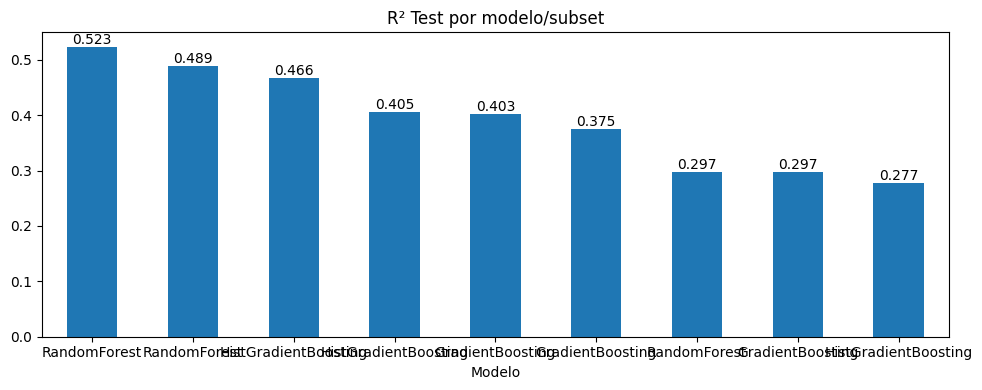

In [29]:
# ================================================================================
# PASO 10: Reentrenos por subconjuntos de variables + Modelos alternativos
# ================================================================================

import numpy as np, pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

# --- 1) Definir subconjuntos desde tu análisis de permutación ---
feat_top3  = ['alcohol','volatile acidity','free sulfur dioxide']
feat_top5  = ['alcohol','volatile acidity','free sulfur dioxide','density','sulphates']
feat_95    = ['alcohol','volatile acidity','free sulfur dioxide','density','sulphates',
              'chlorides','residual sugar','citric acid','pH']  # 95% perm

feature_sets = {
    "Top-3": feat_top3,
    "Top-5": feat_top5,
    "Perm-95% (9 feats)": feat_95
}

# --- 2) Modelos a comparar ---
# Usa tus mejores hiperparámetros encontrados (ajústalos si cambian)
rf_best = RandomForestRegressor(
    n_estimators=602, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features='sqrt', bootstrap=False, random_state=42, n_jobs=-1
)
hgb = HistGradientBoostingRegressor(
    max_depth=None, learning_rate=0.08, max_iter=400, l2_regularization=0.0,
    random_state=42
)
gbr = GradientBoostingRegressor(
    n_estimators=600, learning_rate=0.05, max_depth=3, subsample=0.9,
    random_state=42
)

models = {
    "RandomForest": rf_best,
    "HistGradientBoosting": hgb,
    "GradientBoosting": gbr
}

# --- 3) CV setup ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def neg_rmse(est, X, y):
    # scikit solo trae neg_mean_squared_error; calculamos RMSE aquí para CV manual si hace falta
    y_pred = est.predict(X); return -np.sqrt(mean_squared_error(y, y_pred))

rows = []
for set_name, cols in feature_sets.items():
    Xtr = X_train[cols]; Xte = X_test[cols]
    for mdl_name, mdl in models.items():
        # CV R²
        r2_cv = cross_val_score(mdl, Xtr, y_train, cv=cv, scoring='r2', n_jobs=-1)
        # CV RMSE (custom, usando fit/predict por fold interno via cross_val_score no aplica directo)
        # Hacemos un loop breve para RMSE/MAE por fold:
        rmse_folds, mae_folds = [], []
        for tr_idx, va_idx in cv.split(Xtr):
            X_tr, X_va = Xtr.iloc[tr_idx], Xtr.iloc[va_idx]
            y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
            est = mdl.__class__(**mdl.get_params())
            est.fit(X_tr, y_tr)
            y_hat = est.predict(X_va)
            rmse_folds.append(np.sqrt(mean_squared_error(y_va, y_hat)))
            mae_folds.append(mean_absolute_error(y_va, y_hat))
        # Entrenar en todo TRAIN y evaluar en TEST
        mdl_fit = mdl.fit(Xtr, y_train)
        y_tr_pred = mdl_fit.predict(Xtr)
        y_te_pred = mdl_fit.predict(Xte)
        rows.append({
            "Feature set": set_name,
            "Modelo": mdl_name,
            "R2 CV (mean)": r2_cv.mean(),
            "R2 CV (std)": r2_cv.std(),
            "RMSE CV (mean)": np.mean(rmse_folds),
            "MAE CV (mean)": np.mean(mae_folds),
            "R2 Train": r2_score(y_train, y_tr_pred),
            "R2 Test":  r2_score(y_test,  y_te_pred),
            "RMSE Test": np.sqrt(mean_squared_error(y_test, y_te_pred)),
            "MAE Test":  mean_absolute_error(y_test, y_te_pred)
        })

df_cmp = pd.DataFrame(rows).sort_values(by=["R2 Test","R2 CV (mean)"], ascending=False)
print("\n=== 📊 Comparación por subconjuntos y modelos (ordenado por R² Test) ===")
display(df_cmp.reset_index(drop=True))

# Sugerencia visual mínima
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
ax = df_cmp.plot(x="Modelo", y=["R2 Test"], kind="bar", figsize=(10,4), rot=0,
                 title="R² Test por modelo/subset", legend=False)
for c in ax.containers:
    ax.bar_label(c, fmt="%.3f")
plt.tight_layout(); plt.show()


🚀 XGBoost & LightGBM con interacciones + escalado robusto
🧩 Features usadas (14):
fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, density, pH, sulphates, alcohol, alc_density, sulph_sq, va_sulph, acid_pH_ratio

XGBoost:
   R² = 0.5008
   RMSE = 0.6201
   MAE = 0.4289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2117
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 14
[LightGBM] [Info] Start training from score 5.816335

XGBoost:
   R² = 0.5008
   RMSE = 0.6201
   MAE = 0.4289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2117
[LightGBM] [Info] Number of data points in the train set: 4677, number of used features: 14

c:\Users\juanc\OneDrive\Documentos\GitHub\ml-tarea1-vinos\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,Modelo,R2 Test,RMSE Test,MAE Test
0,XGBoost,0.500826,0.620136,0.428867
1,LightGBM,0.487759,0.628201,0.444011


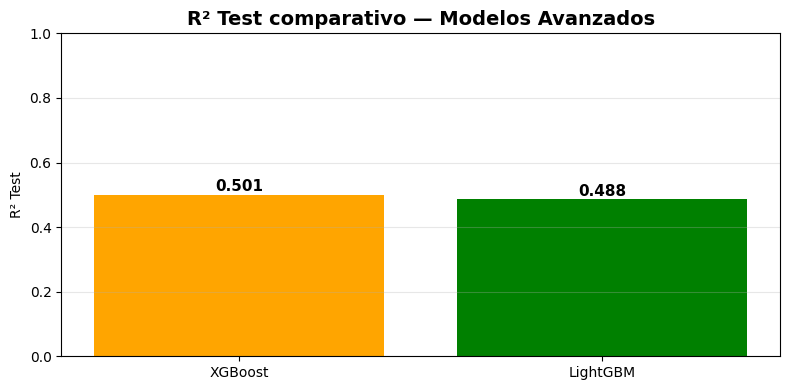

In [34]:
# ================================================================================
# PASO 12: XGBoost + LightGBM con interacciones y escalado robusto
# ================================================================================

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np, pandas as pd, matplotlib.pyplot as plt

print("="*80)
print("🚀 XGBoost & LightGBM con interacciones + escalado robusto")
print("="*80)

# ---------------------------------------------------------------------
# 1️⃣ Crear nuevas variables de interacción
# ---------------------------------------------------------------------
X_train_int = X_train.copy()
X_test_int  = X_test.copy()

def add_interactions(df):
    df = df.copy()
    if all(col in df.columns for col in ["alcohol","density"]):
        df["alc_density"] = df["alcohol"] * df["density"]
    if "sulphates" in df.columns:
        df["sulph_sq"] = df["sulphates"]**2
    if all(col in df.columns for col in ["volatile acidity","sulphates"]):
        df["va_sulph"] = df["volatile acidity"] * df["sulphates"]
    if all(col in df.columns for col in ["citric acid","pH"]):
        df["acid_pH_ratio"] = df["citric acid"] / (df["pH"] + 1e-6)
    return df

X_train_int = add_interactions(X_train_int)
X_test_int  = add_interactions(X_test_int)

# Subconjunto de features relevantes (los 9 principales + nuevas)
features_used = list(X_train_int.columns)

print(f"🧩 Features usadas ({len(features_used)}):")
print(", ".join(features_used))

# ---------------------------------------------------------------------
# 2️⃣ Preprocesamiento: Escalado robusto
# ---------------------------------------------------------------------
scaler = ColumnTransformer([
    ("num", RobustScaler(), features_used)
], remainder='drop')

# ---------------------------------------------------------------------
# 3️⃣ Definir modelos
# ---------------------------------------------------------------------
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

models = {
    "XGBoost": xgb,
    "LightGBM": lgbm
}

# ---------------------------------------------------------------------
# 4️⃣ Entrenamiento + Evaluación
# ---------------------------------------------------------------------
results = []
for name, model in models.items():
    pipe = Pipeline([
        ("scaler", scaler),
        ("model", model)
    ])
    pipe.fit(X_train_int, y_train)
    y_pred = pipe.predict(X_test_int)
    
    r2  = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    
    results.append({
        "Modelo": name,
        "R2 Test": r2,
        "RMSE Test": rmse,
        "MAE Test": mae
    })
    print(f"\n{name}:")
    print(f"   R² = {r2:.4f}")
    print(f"   RMSE = {rmse:.4f}")
    print(f"   MAE = {mae:.4f}")

# ---------------------------------------------------------------------
# 5️⃣ Resultados comparativos
# ---------------------------------------------------------------------
df_res = pd.DataFrame(results).sort_values(by="R2 Test", ascending=False)
print("\n📊 Resultados comparativos (ordenado por R² Test):")
display(df_res)

# ---------------------------------------------------------------------
# 6️⃣ Visualización
# ---------------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.bar(df_res["Modelo"], df_res["R2 Test"], color=["orange","green"])
for i, v in enumerate(df_res["R2 Test"]):
    plt.text(i, v+0.01, f"{v:.3f}", ha="center", fontsize=11, fontweight='bold')
plt.title("R² Test comparativo — Modelos Avanzados", fontsize=14, fontweight='bold')
plt.ylim(0,1)
plt.ylabel("R² Test")
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()



In [35]:
# ================================================================================
# PASO 13: OPTIMIZACIÓN (RandomizedSearchCV) para XGBoost y LightGBM
# ================================================================================

print("="*80)
print("🔍 OPTIMIZACIÓN DE HIPERPARÁMETROS (XGBoost & LightGBM) — 5-FOLD CV (R²)")
print("="*80)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import randint, uniform, loguniform

# Modelos
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ---------------------------
# 1) Interacciones (reuso)
# ---------------------------
def add_interactions(df):
    df = df.copy()
    if all(col in df.columns for col in ["alcohol","density"]):
        df["alc_density"] = df["alcohol"] * df["density"]
    if "sulphates" in df.columns:
        df["sulph_sq"] = df["sulphates"]**2
    if all(col in df.columns for col in ["volatile acidity","sulphates"]):
        df["va_sulph"] = df["volatile acidity"] * df["sulphates"]
    if all(col in df.columns for col in ["citric acid","pH"]):
        df["acid_pH_ratio"] = df["citric acid"] / (df["pH"] + 1e-6)
    return df

X_train_int = add_interactions(X_train)
X_test_int  = add_interactions(X_test)
features_used = list(X_train_int.columns)

# ---------------------------
# 2) Preprocesamiento
# ---------------------------
scaler = ColumnTransformer([
    ("num", RobustScaler(), features_used)
], remainder="drop")

# ---------------------------
# 3) Espacios de búsqueda
# ---------------------------
# XGBoost (API sklearn)
xgb_base = XGBRegressor(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",           # rápido y estable
    subsample=0.8,
    colsample_bytree=0.8,
)

xgb_param_dist = {
    "model__max_depth": randint(3, 9),                 # 3..8
    "model__learning_rate": loguniform(1e-3, 2e-1),    # ~[0.001, 0.2]
    "model__min_child_weight": randint(1, 10),
    "model__gamma": loguniform(1e-8, 1e-1),
    "model__reg_lambda": loguniform(1e-2, 1e2),        # L2
    "model__reg_alpha": loguniform(1e-6, 1e-1),        # L1
    "model__subsample": uniform(0.6, 0.4),             # 0.6..1.0
    "model__colsample_bytree": uniform(0.6, 0.4),      # 0.6..1.0
}

# LightGBM
lgb_base = LGBMRegressor(
    n_estimators=1200,
    random_state=42,
    n_jobs=-1,
    boosting_type="gbdt",
)

lgb_param_dist = {
    "model__num_leaves": randint(16, 64),
    "model__max_depth": randint(-1, 12),      # -1 significa sin límite
    "model__learning_rate": loguniform(1e-3, 2e-1),
    "model__min_child_samples": randint(5, 60),
    "model__subsample": uniform(0.6, 0.4),          # bagging_fraction
    "model__colsample_bytree": uniform(0.6, 0.4),   # feature_fraction
    "model__reg_lambda": loguniform(1e-2, 1e2),
}

# ---------------------------
# 4) RandomizedSearchCV (ambos)
# ---------------------------
def randomized_search(model_name, base_estimator, param_distributions):
    pipe = Pipeline([
        ("scaler", scaler),
        ("model", base_estimator)
    ])
    rs = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=60,                 # puedes subir a 100 si tienes tiempo
        cv=5,
        scoring="r2",
        random_state=42,
        n_jobs=-1,
        verbose=2,
        return_train_score=True
    )
    print(f"\n⏳ Buscando hiperparámetros para {model_name} ...")
    rs.fit(X_train_int, y_train)
    print(f"✅ {model_name} — Búsqueda finalizada")
    return rs

rs_xgb = randomized_search("XGBoost", xgb_base, xgb_param_dist)
rs_lgb = randomized_search("LightGBM", lgb_base, lgb_param_dist)

# ---------------------------
# 5) Resultados y evaluación en TEST
# ---------------------------
def eval_best(name, search_obj):
    best = search_obj.best_estimator_
    best_params = search_obj.best_params_
    best_cv = search_obj.best_score_
    y_pred = best.predict(X_test_int)
    r2  = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)

    print("\n" + "-"*80)
    print(f"🏆 {name} — Mejores hiperparámetros (CV=5, métrica=R²)")
    for k,v in best_params.items():
        print(f"• {k}: {v}")
    print(f"📈 Mejor R² (CV): {best_cv:.4f}")

    print(f"\n📊 {name} — Métricas en TEST")
    print(f"   R²   : {r2:.4f}")
    print(f"   RMSE : {rmse:.4f}")
    print(f"   MAE  : {mae:.4f}")

    return {
        "Modelo": name,
        "R2 CV (best)": best_cv,
        "R2 Test": r2,
        "RMSE Test": rmse,
        "MAE Test": mae,
        "Best Params": best_params,
        "Best Estimator": best
    }

res_xgb = eval_best("XGBoost", rs_xgb)
res_lgb = eval_best("LightGBM", rs_lgb)

# ---------------------------
# 6) Comparativa y gráfico
# ---------------------------
df_best = pd.DataFrame([
    {k:v for k,v in res_xgb.items() if k not in ["Best Estimator"]},
    {k:v for k,v in res_lgb.items() if k not in ["Best Estimator"]}
]).sort_values("R2 Test", ascending=False)

print("\n" + "="*80)
print("📋 RESUMEN COMPARATIVO (ordenado por R² Test)")
print("="*80)
display(df_best[["Modelo","R2 CV (best)","R2 Test","RMSE Test","MAE Test"]])

plt.figure(figsize=(7,4))
plt.bar(df_best["Modelo"], df_best["R2 Test"])
for i,v in enumerate(df_best["R2 Test"]):
    plt.text(i, v+0.01, f"{v:.3f}", ha="center", fontweight="bold")
plt.ylim(0,1)
plt.title("R² Test — Mejores modelos tras RandomizedSearchCV")
plt.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

# (Opcional) Acceder al mejor pipeline final
best_overall = res_xgb if res_xgb["R2 Test"] >= res_lgb["R2 Test"] else res_lgb
print(f"\n✅ Mejor modelo final: {best_overall['Modelo']} | R² Test = {best_overall['R2 Test']:.4f}")


🔍 OPTIMIZACIÓN DE HIPERPARÁMETROS (XGBoost & LightGBM) — 5-FOLD CV (R²)

⏳ Buscando hiperparámetros para XGBoost ...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
✅ XGBoost — Búsqueda finalizada

⏳ Buscando hiperparámetros para LightGBM ...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
✅ XGBoost — Búsqueda finalizada

⏳ Buscando hiperparámetros para LightGBM ...
Fitting 5 folds for each of 60 candidates, totalling 300 fits


KeyboardInterrupt: 